## Import

In [1]:
import os
from os.path import dirname
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import scipy.stats as stats
import seaborn as sns

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

## color and saving

In [2]:
color = "#9a3324"

cmap_color_end = "#00274C"
cmap_color_start = "#FFCB05"
cmap_name = "maize2blue"

folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig2_diffusion analysis/multi_stage_diffusion_examples"
os.chdir(folder_save)

switch_read_from_file = False
switch_savefig = True

In [3]:
if switch_read_from_file:
    df_load = pd.read_csv(fname_save_prefix + "-data.csv")
    t = df_load[df_load["variable"] == "t_s"]["value"].to_numpy(dtype=float)
    x = df_load[df_load["variable"] == "x_nm"]["value"].to_numpy(dtype=float)
    y = df_load[df_load["variable"] == "y_nm"]["value"].to_numpy(dtype=float)
    MSD = df_load[df_load["variable"] == "MSD_um2"]["value"].to_numpy(dtype=float)
    tau = df_load[df_load["variable"] == "tau_s"]["value"].to_numpy(dtype=float)
    length = MSD.shape[0]
    half_length = round(length / 2)

## Filtering and find track

In [14]:
df = pd.read_csv("SPT_results_AIO_concat-multistage examples.csv")
idx = 0

In [15]:
nm_per_pxl = 117
um_per_pixel = 0.117
s_per_frame = 0.02

x = np.fromstring(df.iloc[idx]["list_of_x"][1:-1], sep=", ")
y = np.fromstring(df.iloc[idx]["list_of_y"][1:-1], sep=", ")
t = np.fromstring(df.iloc[idx]["list_of_t"][1:-1], sep=", ")
MSD = np.fromstring(df.iloc[idx]["list_of_MSD_um2"][1:-1], sep=", ")
tau = np.fromstring(df.iloc[idx]["list_of_tau_s"][1:-1], sep=", ")
x = (x - (x.min() + x.max()) / 2) * nm_per_pxl
y = (y - (y.min() + y.max()) / 2) * nm_per_pxl
t = (t - t[0]) * s_per_frame

fname_save_prefix = "multistage-" + str(idx)
# idx += 1

## Plot RNA track

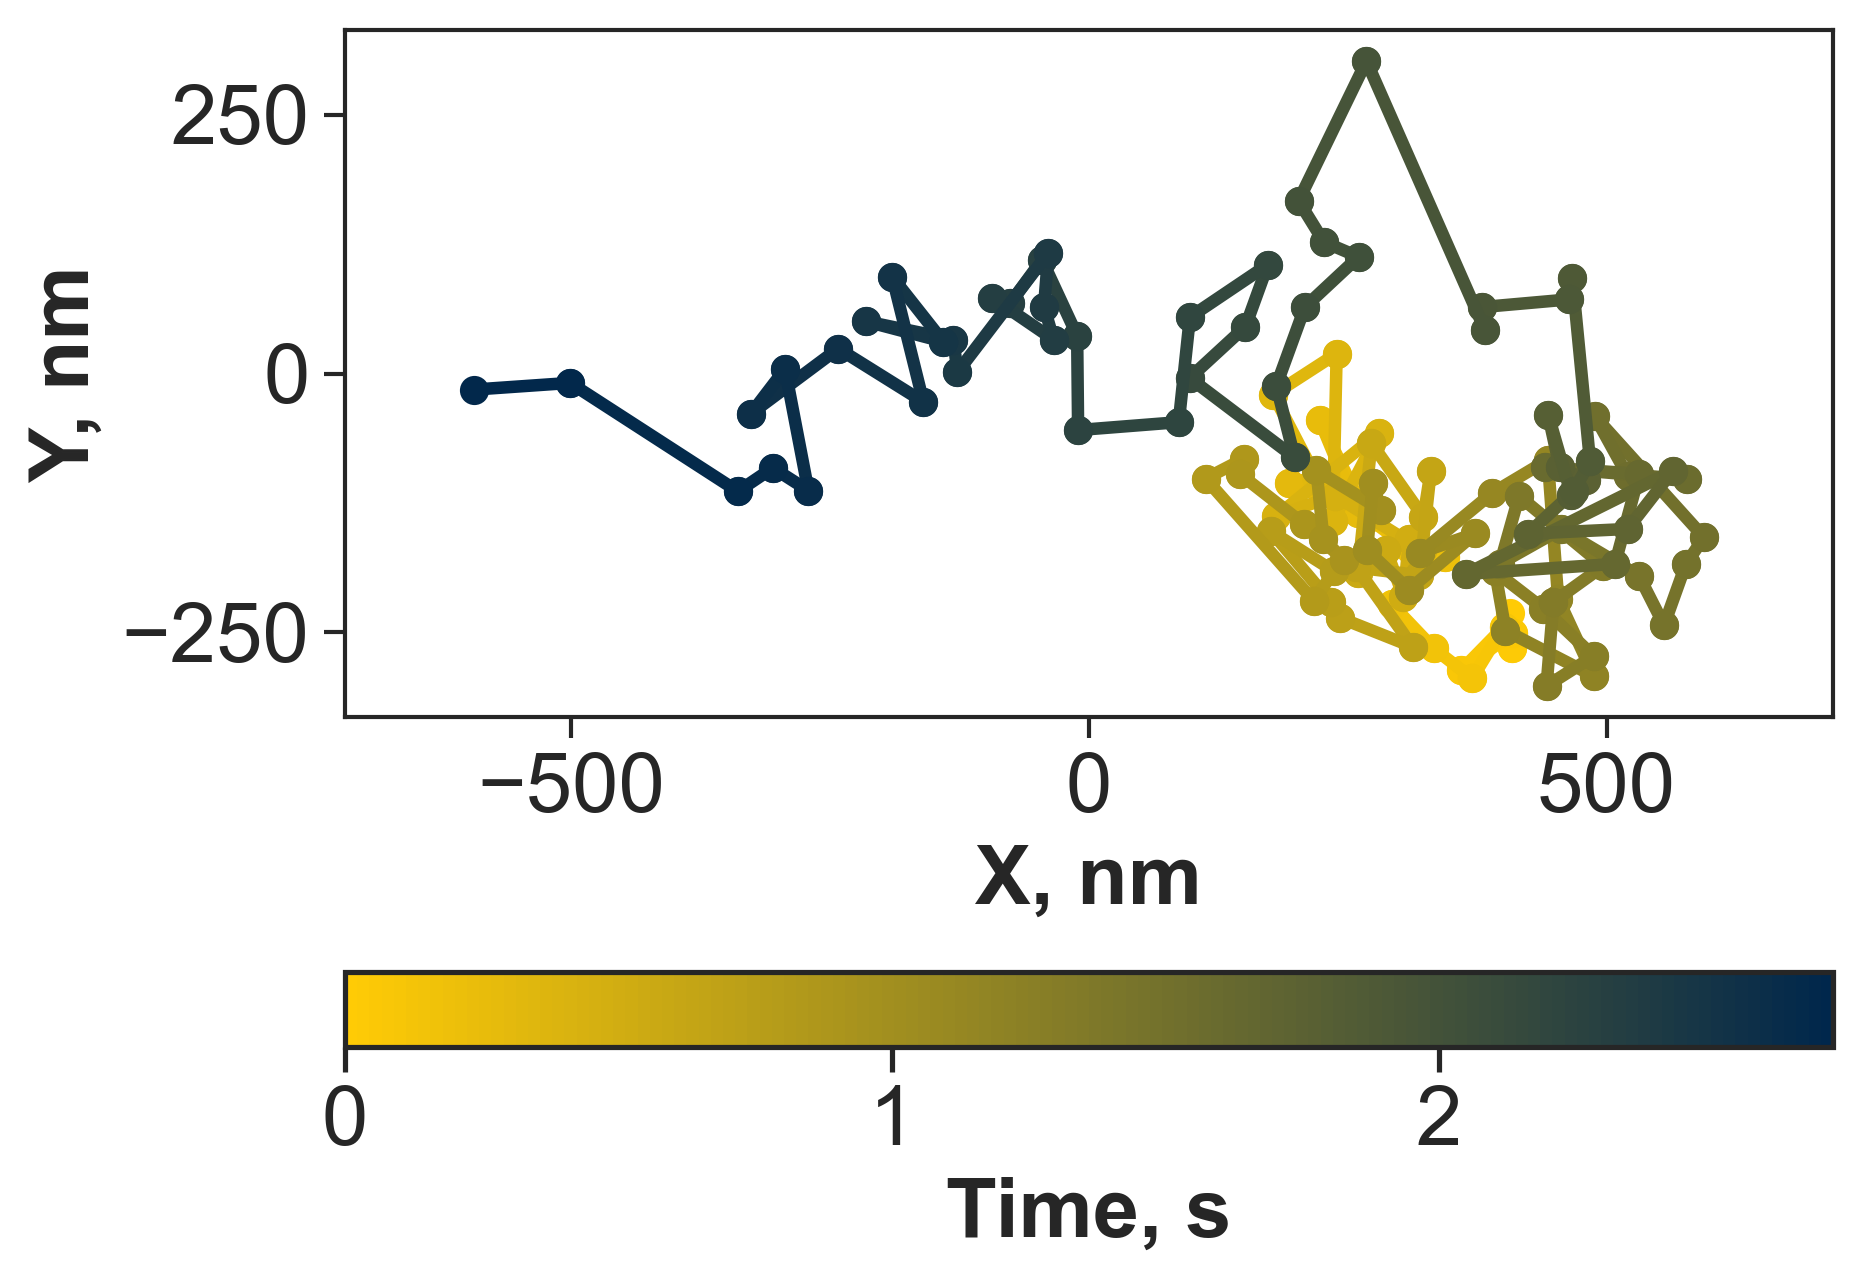

In [67]:
cmap = clr.LinearSegmentedColormap.from_list(
    cmap_name, [cmap_color_start, cmap_color_end], N=x.shape[0]
)

# Adjust track
t_plot = t
x_plot = x - (x.min() + x.max()) / 2
y_plot = -(y - (y.min() + y.max()) / 2)
# y_plot = -(x - (x.min() + x.max()) / 2)
# x_plot = -(y - (y.min() + y.max()) / 2)

fig = plt.figure(dpi=300)
for i in range(len(t_plot) - 1):
    plt.plot(
        x_plot[i : i + 2],
        y_plot[i : i + 2],
        "-o",
        color=cmap(i / len(t_plot)),
        linewidth=3,
    )

# tick number and sizes
plt.gca().axis("equal")
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=20,
    direction="out",
    bottom=True,
    left=True,
    length=5,
    width=1,
)

# xy_max = np.max([x_plot.max(), y_plot.max()])
# plt.gca().set_xlim(-xy_max, xy_max)
# plt.gca().set_ylim(-xy_max, xy_max)
plt.gca().xaxis.set_major_locator(MaxNLocator(3))
plt.gca().yaxis.set_major_locator(MaxNLocator(3))


# color bar
cbar = plt.colorbar(
    cm.ScalarMappable(norm=clr.Normalize(t[0], t[-1]), cmap=cmap),
    ax=plt.gca(),
    orientation="horizontal",
    pad=0.23,
    drawedges=False,
)
cbar.set_label(label="Time, s", weight="bold", fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.xlabel("X, nm", fontsize=20, weight="bold")
plt.ylabel("Y, nm", fontsize=20, weight="bold")


# saving
if switch_savefig:
    plt.savefig(
        fname_save_prefix + "-track.png",
        format="png",
        dpi=300,
        bbox_inches="tight",
    )
plt.show()

## Running window analysis

In [19]:
def calc_MSD_NonPhysUnit(df_track, lags):
    df_track_sorted = df_track.sort_values("t")
    # prepare storage arrays
    MSDs = []
    # STDs = np.array([], dtype=float)

    # filling gaps
    ref_t = list(range(df_track_sorted.t.min(), df_track_sorted.t.max()))
    missing_t = list(set(ref_t) - set(df_track_sorted.t))
    if len(missing_t) > 0:
        for t in missing_t:
            complete_t = np.append(df_track_sorted.t, np.array(missing_t, dtype=int))
            complete_x = np.append(df_track_sorted.x, np.repeat(np.NaN, len(missing_t)))
            complete_y = np.append(df_track_sorted.y, np.repeat(np.NaN, len(missing_t)))
            df_complete = pd.DataFrame()
            df_complete["x"] = complete_x
            df_complete["y"] = complete_y
            df_complete["t"] = complete_t
            df_complete = df_complete.sort_values("t")

    else:
        df_complete = df_track_sorted

    # calculate MSDs corresponding to a series of lag times
    for lag in lags:
        Xs = np.array(df_complete.x, dtype=float)
        Ys = np.array(df_complete.y, dtype=float)

        SquareDisplacements = (Xs[lag:] - Xs[:-lag]) ** 2 + (Ys[lag:] - Ys[:-lag]) ** 2
        MSD = np.nanmean(SquareDisplacements)
        MSDs.append(MSD)

    MSDs = np.array(MSDs, dtype=float)
    return MSDs

In [20]:
df_track = pd.DataFrame(
    {
        "t": (t / s_per_frame).astype(int),
        "x": x / nm_per_pxl,
        "y": y / nm_per_pxl,
    }
)

In [43]:
lags = np.array(
    [
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        # 16,
        # 17,
        # 18,
        # 19,
        # 20,
    ]
)

In [53]:
lst_t_mean = []
lst_log10D = []
lst_alpha = []
for i in range(df_track.shape[0] - lags.shape[0] * 2):
    MSDs = calc_MSD_NonPhysUnit(df_track.iloc[i : i + lags.shape[0] * 2], lags)
    lags_phys = lags * s_per_frame
    MSDs_phys = MSDs * (um_per_pixel**2)
    slope_linear, intercept_linear, R_linear, P, std_err = stats.linregress(
        lags_phys, MSDs_phys
    )
    D_phys_linear = slope_linear / (8 / 3)  # um^2/s
    slope_loglog, intercept_loglog, R_loglog, P, std_err = stats.linregress(
        np.log10(lags_phys),
        np.log10(MSDs_phys),
    )
    log10D_loglog = intercept_loglog - np.log10(4)
    alpha = slope_loglog

    lst_t_mean.append(df_track.iloc[i : i + 5]["t"].mean() * s_per_frame)
    lst_log10D.append(D_phys_linear)
    lst_alpha.append(alpha)

In [54]:
convolve_t = np.array(lst_t_mean, dtype=float)
convolve_t = convolve_t - convolve_t[0]
convolve_log10D = np.array(lst_log10D, dtype=float)
convolve_alpha = np.array(lst_alpha, dtype=float)

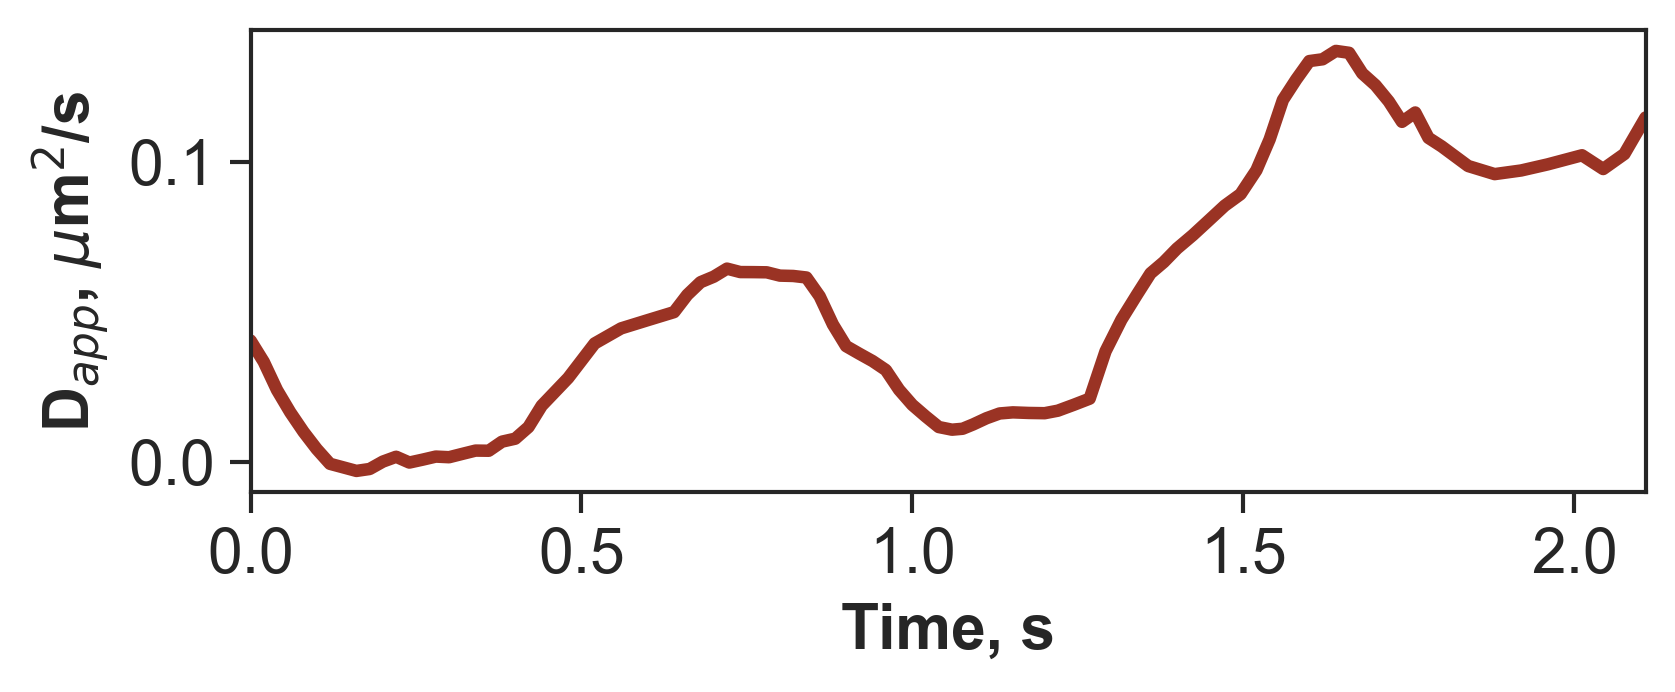

In [69]:
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(convolve_t, convolve_log10D, lw=3, c="#9a3324")
plt.xlabel("Time, s", weight="bold", fontsize=15)
plt.ylabel(r"D$_{app}$, $\mu$m$^2$/s", weight="bold", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="out",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.xlim(convolve_t[0], convolve_t[-1])
plt.savefig(
    "running_window_log10D-" + str(idx) + ".png", format="png", bbox_inches="tight"
)
plt.show()

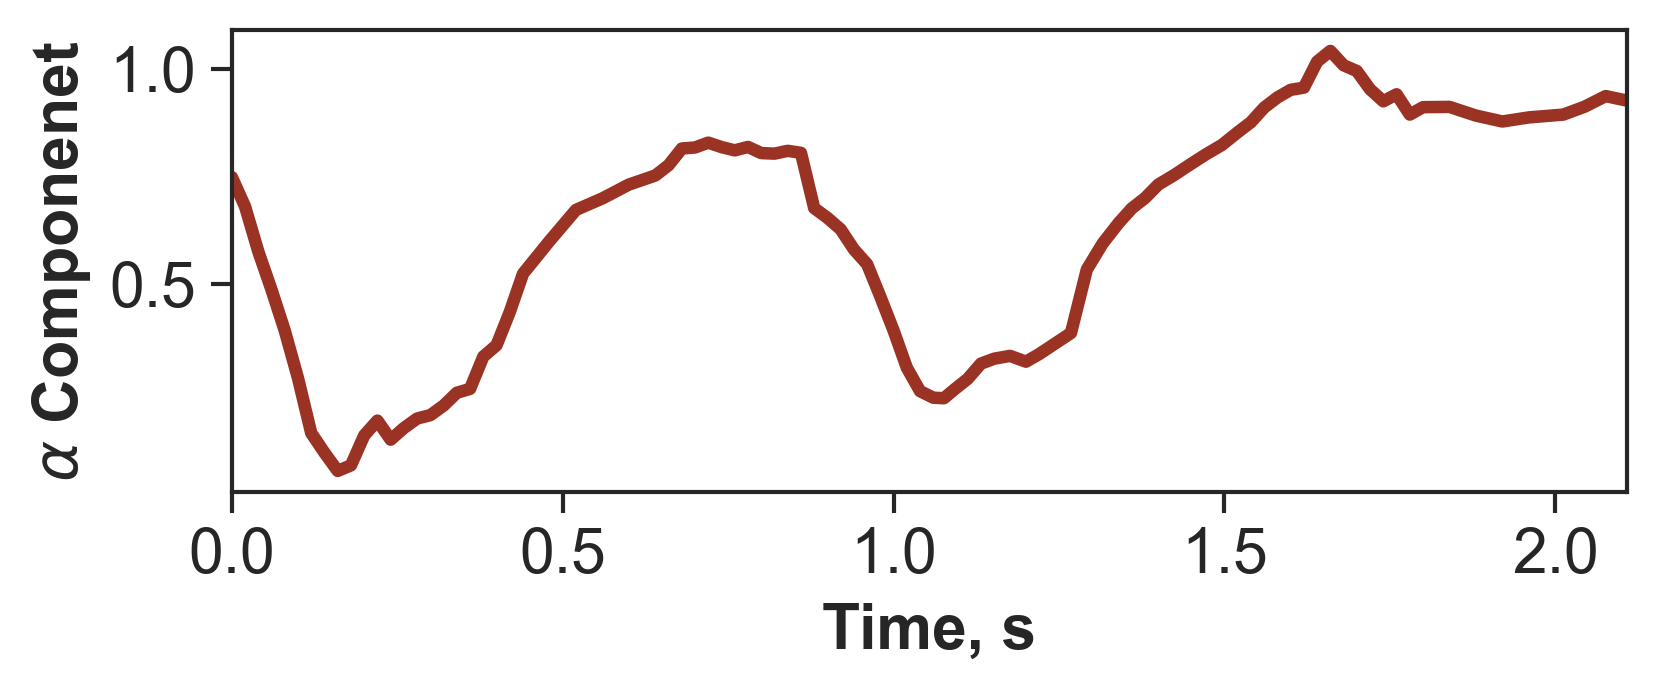

In [68]:
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(convolve_t, convolve_alpha, lw=3, c="#9a3324")
plt.xlabel("Time, s", weight="bold", fontsize=15)
plt.ylabel(r"$\alpha$ Componenet", weight="bold", fontsize=15)
# plt.axhline(1, ls="--", color="black")
# plt.axhline(0, ls="--", color="black")
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=15,
    direction="out",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.xlim(convolve_t[0], convolve_t[-1])
plt.savefig(
    "running_window_alhpa-" + str(idx) + ".png", format="png", bbox_inches="tight"
)
plt.show()